In [1]:
!pip install numpy scipy matplotlib

import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.io.wavfile import write
import random

## Task 3.1

No suspicious data found in sounds/Ex3_sound1.wav
No suspicious data found in sounds/Ex3_sound2.wav
No suspicious data found in sounds/Ex3_sound3.wav
Suspicious data detected in sounds/Ex3_sound4.wav
Demodulated secret code saved as 'sounds/secret_code.wav'.


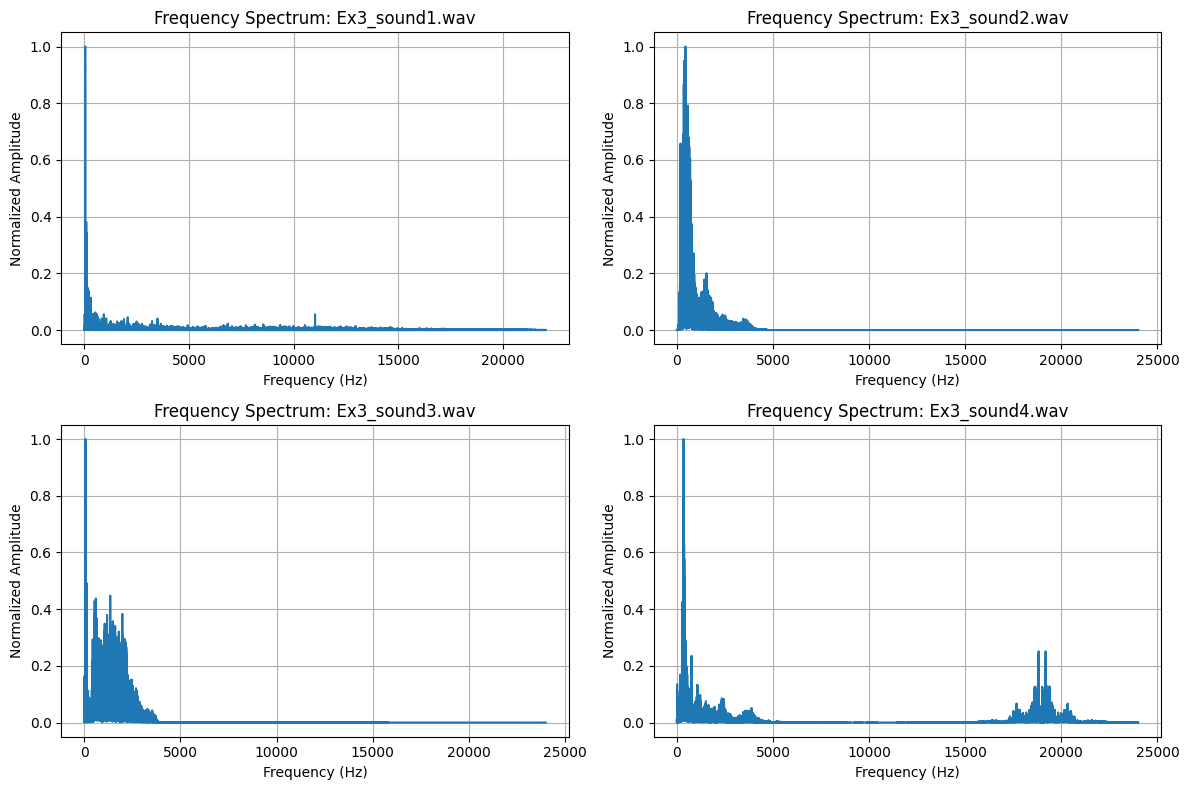

In [2]:
def analyze_audio(file_path, subplot_position, fig):
    """
    Analyze the audio file to detect ultrasonic data in the 20–25 kHz range and plot the spectrum in a 2x2 grid.
    """
    try:
        # Load the audio file
        rate, data = wav.read(file_path)

        # Convert stereo to mono (average channels)
        if len(data.shape) > 1:
            data = np.mean(data, axis=1).astype(data.dtype)

        # Perform Fourier Transform
        spectrum = np.fft.fft(data)
        freqs = np.fft.fftfreq(len(data), d=1/rate)
        magnitude = np.abs(spectrum)

        # Normalize the magnitude
        normalized_magnitude = magnitude / np.max(magnitude)

        # Plot Frequency Spectrum in the given subplot position
        ax = fig.add_subplot(2, 2, subplot_position)
        ax.plot(freqs[:len(freqs)//2], normalized_magnitude[:len(freqs)//2])
        ax.set_title(f"Frequency Spectrum: {file_path.split('/')[-1]}")
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Normalized Amplitude")
        ax.grid()

        # Check for ultrasonic frequencies (20–25 kHz)
        ultrasonic_indices = (freqs > 20000) & (freqs < 25000)
        ultrasonic_magnitude = normalized_magnitude[ultrasonic_indices]

        # Adjust threshold dynamically
        threshold = 0.05  # Detect peaks above 5% of the max magnitude
        if np.any(ultrasonic_magnitude > threshold):
            print(f"Suspicious data detected in {file_path}")
            return file_path, rate, data

        print(f"No suspicious data found in {file_path}")
        return None, None, None

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None, None

def process_audio_files(files):
    """
    Process a list of audio files to detect suspicious data and plot the spectrum in a 2x2 grid.
    """
    fig = plt.figure(figsize=(12, 8))
    for i, file in enumerate(files, start=1):
        suspicious_file, rate, data = analyze_audio(file, i, fig)
        if suspicious_file:
            demodulated_data = demodulate_signal(rate, data)
            if demodulated_data is not None:
                # Save the demodulated audio to a file
                output_file = "sounds/secret_code.wav"
                write(output_file, rate, demodulated_data)
                print(f"Demodulated secret code saved as '{output_file}'.")
                break
    plt.tight_layout()
    plt.show()

def demodulate_signal(rate, data):
    """
    Demodulate the signal by extracting its amplitude envelope using the Hilbert transform.
    """
    try:
        # Perform Hilbert transform to get the envelope
        analytic_signal = hilbert(data)
        envelope = np.abs(analytic_signal)

        # Scale the envelope into an audible range
        scaled = envelope * (np.max(np.abs(data)) / np.max(envelope))
        return scaled.astype(np.int16)
    except Exception as e:
        print(f"Error during demodulation: {e}")
        return None

# List of audio files to analyze
files = [
    "sounds/Ex3_sound1.wav",
    "sounds/Ex3_sound2.wav",
    "sounds/Ex3_sound3.wav",
    "sounds/Ex3_sound4.wav"
]

# Process the files
process_audio_files(files)


## Task 3.2

In [3]:
def embed_message(audio_file, message, output_file):
    rate, data = wav.read(audio_file)
    if len(data.shape) > 1:  # Handle stereo files
        data = data[:, 0]
    
    message_bin = ''.join(f'{ord(c):08b}' for c in message)
    random.seed(42)  # For reproducibility
    positions = random.sample(range(len(data)), len(message_bin))
    
    data = data.copy()
    for i, bit in enumerate(message_bin):
        pos = positions[i]
        data[pos] = (data[pos] & ~1) | int(bit)
    
    write(output_file, rate, data)
    print(f"Message embedded and saved to {output_file}.")

def extract_message(audio_file, message_length):
    rate, data = wav.read(audio_file)
    if len(data.shape) > 1:
        data = data[:, 0]
    
    random.seed(42)
    positions = random.sample(range(len(data)), message_length * 8)
    message_bin = ''.join(str(data[pos] & 1) for pos in positions)
    message = ''.join(chr(int(message_bin[i:i+8], 2)) for i in range(0, len(message_bin), 8))
    return message

embed_message("sounds/Ex3_sound5.wav", "An eye for an eye makes the whole world blind", "sounds/embedded_sound.wav")
extracted_message = extract_message("sounds/embedded_sound.wav", len("An eye for an eye makes the whole world blind"))
print(f"Extracted Message: {extracted_message}")


Message embedded and saved to sounds/embedded_sound.wav.
Extracted Message: An eye for an eye makes the whole world blind


/var/folders/63/qnkgf96s2d34170xtlqt1ypc0000gn/T/ipykernel_51256/1610703616.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wav.read(audio_file)
